# Lab 1

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy import optimize
from scipy import stats
from scipy.stats.distributions import gamma, expon, norm, chi2
import seaborn as sns
from IPython.display import display, Math
from functools import partial

## Step 1. Choose subsample with main variables for your further analysis

In [2]:
path_to_file = '/opt/notebooks/owid-covid-data.csv'
source_df = pd.read_csv(path_to_file)

df = source_df[['hospital_beds_per_thousand', 'excess_mortality_cumulative', 'excess_mortality_cumulative_per_million']].copy().dropna()

In [3]:
df.head(5)

,hospital_beds_per_thousand,excess_mortality_cumulative,excess_mortality_cumulative_per_million
1975,2.89,-4.34,-66.836912
2006,2.89,-2.59,-57.799216
2036,2.89,-1.17,-33.278337
2067,2.89,0.24,8.056860
2097,2.89,1.65,65.856076


## Step 2. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).

In [4]:
from scipy.stats import kde

def kernel_density_estimation(x, bins):
    density = kde.gaussian_kde(x)
    xgrid = np.linspace(x.min(), x.max(), 100)
    mpl.rcParams['figure.dpi'] = 100
    plt.hist(x, bins=bins, density = True)
    plt.plot(xgrid, density(xgrid), 'r-')

### Hospital beds per thousand

In [5]:
beds = df['hospital_beds_per_thousand']

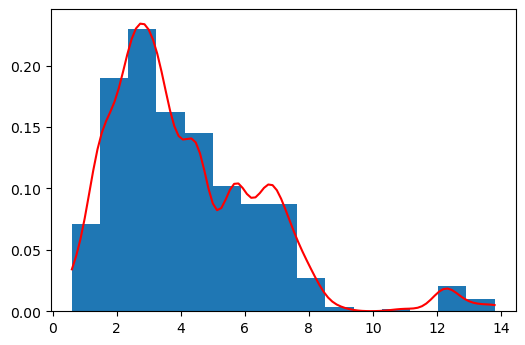

In [6]:
kernel_density_estimation(beds, 15)

### Excess mortality cumulative per million

In [7]:
emcpm = df['excess_mortality_cumulative_per_million'].dropna()

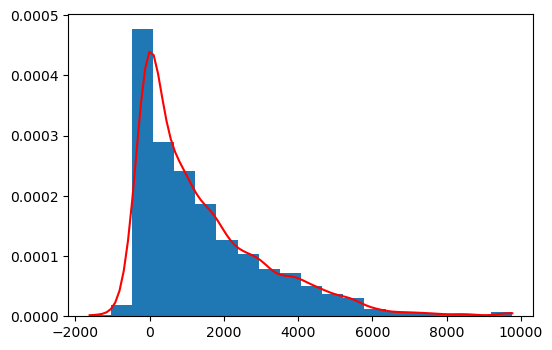

In [8]:
kernel_density_estimation(emcpm, 20)

### Exces mortality cumulative

In [9]:
emc = df['excess_mortality_cumulative'].dropna()
emc = (emc - emc.mean()) / emc.std()

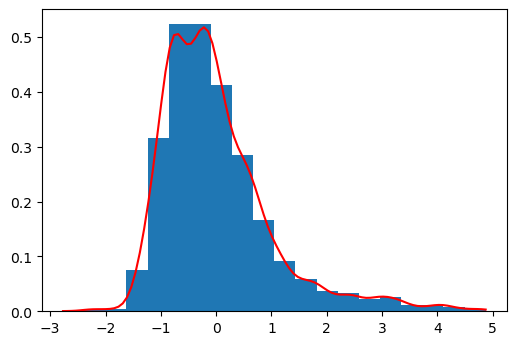

In [10]:
kernel_density_estimation(emc, 20)

## Step 3. You need to make an estimation of order statistics and represent them as "box with whiskers" plot.

In [11]:
pd.DataFrame(
    [
        ['Hospital beds per thousand (HBpT)', beds.min(), beds.max(), beds.mean(), beds.var(), beds.median(), np.percentile(beds, 25), np.percentile(beds, 75)],
        ['Excess mortality cumulative per million (EMCpM)', emcpm.min(), emcpm.max(), emcpm.mean(), emcpm.var(), emcpm.median(), np.percentile(emcpm, 25), np.percentile(emcpm, 75)],
        ['Excess mortality cumulative (EMC)', emc.min(), emc.max(), emc.mean(), emc.var(), emc.median(), np.percentile(emc, 25), np.percentile(emc, 75)]
    ],
    columns=['Random Variable', 'min', 'max', 'mean', 'variance', 'median', 'Q1', 'Q3']
)

,Random Variable,min,max,mean,variance,median,Q1,Q3
0,Hospital beds per thousand (HBpT),0.600000,13.800000,4.141610e+00,5.696218e+00,3.400000,2.500000,5.640000
1,Excess mortality cumulative per million (EMCpM),-1618.296234,9771.680201,1.406617e+03,3.073219e+06,856.638066,37.107368,2228.354760
2,Excess mortality cumulative (EMC),-2.769131,4.872411,-1.897810e-15,1.000000e+00,-0.197925,-0.707606,0.422077


In [12]:
beds_norm = (beds - beds.mean()) / beds.std()
emc_norm = (emc - emc.mean()) / emc.std()
emcpm_norm = (emcpm - emcpm.mean()) / emcpm.std()

{'whiskers': [<matplotlib.lines.Line2D at 0xffff785adf40>,
 'caps': [<matplotlib.lines.Line2D at 0xffff785c0520>,
 'boxes': [<matplotlib.lines.Line2D at 0xffff785adc70>,
 'medians': [<matplotlib.lines.Line2D at 0xffff785c0ac0>,
 'fliers': [],
 'means': []}

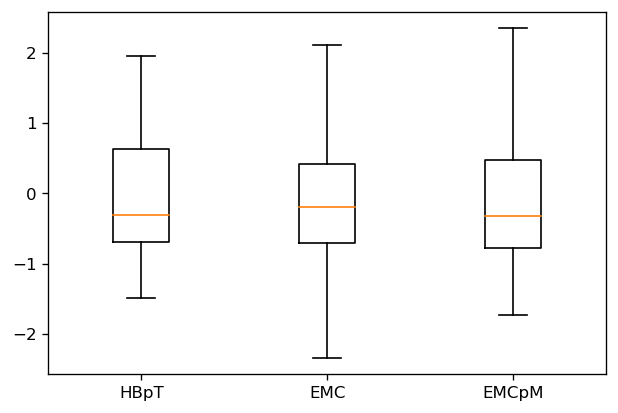

In [13]:
fig1, (ax1) = plt.subplots(1, 1, dpi=120)
plt.subplots_adjust(wspace=0.4)
ax1.boxplot(
    (beds_norm, emc_norm, emcpm_norm),
    labels=('HBpT', 'EMC', 'EMCpM'),
    showfliers=False
)

# ax2.boxplot(
#     ((), emca),
#     labels=('', 'EMCA'),
#     showfliers=False
# )

## Step 4. Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results

### Hospital beds per thousand

It seems like a **gamma distribution**:

$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$

### Excess mortality cumulative per million

It seems like a **chi-squared** distribution

### Excess mortality cumulative

It seems like a **Normal distribution**.

## Step 5. Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method

In [14]:
def lsm_loss(func, data, params):
    space = np.linspace(0.01, 0.95)
    quantile = np.quantile(data, space)
    quantile_approximation = func.ppf(space, *params)
    
    return quantile - quantile_approximation

### Hospital beds per thousand

#### Maximum likelihood method

In [15]:
beds_mle = gamma.fit(beds, method='MLE')

beds_mle

(2.6647095515313537, 0.2906664539618756, 1.4451627374254643)

#### Least squares method

In [16]:
beds_lsm = optimize.least_squares(partial(lsm_loss, gamma, beds), (1.0, 1.0, 1.0)).x

In [17]:
beds_lsm

array([3.14724894, 0.04803831, 1.29378808])

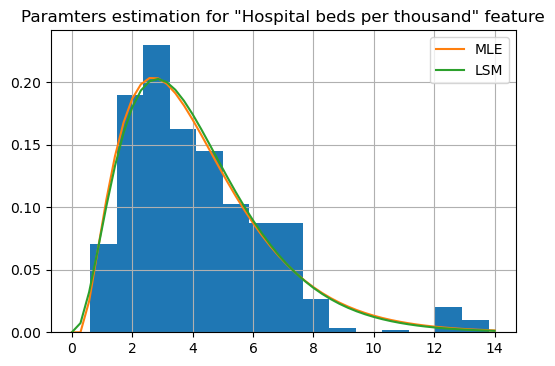

In [18]:
from scipy.stats.distributions import gamma

mpl.rcParams['figure.dpi'] = 100
beds.hist(bins=15, density=True)
plt.plot(np.linspace(0, 14), gamma.pdf(np.linspace(0, 14), *beds_mle), label='MLE')
plt.plot(np.linspace(0, 14), gamma.pdf(np.linspace(0, 14), *beds_lsm), label='LSM')
plt.title('Paramters estimation for "Hospital beds per thousand" feature')
plt.legend()

### Excess mortality cumulative per million

#### Maximum likelihood method

In [19]:
emcpm_mle = chi2.fit(emcpm, method='MLE')

emcpm_mle

(7.331072577193601, -1630.974810623707, 414.77672984116435)

#### Least squares method

In [20]:
emcpm_lsm = optimize.least_squares(partial(lsm_loss, chi2, emcpm), (1.0, 1.0, 1.0)).x

In [21]:
emcpm_lsm

array([   2.04690013, -447.22886375,  922.16882718])

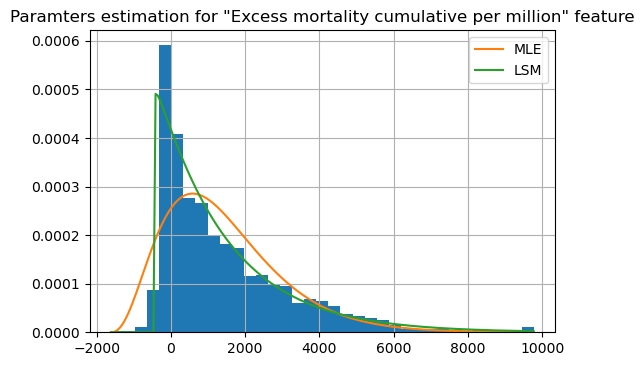

In [22]:
mpl.rcParams['figure.dpi'] = 100
emcpm.hist(bins=35, density=True)
space = np.linspace(min(emcpm), max(emcpm), 200)
plt.plot(space, chi2.pdf(space, *emcpm_mle), label='MLE')
plt.plot(space, chi2.pdf(space, *emcpm_lsm), label='LSM')
plt.title('Paramters estimation for "Excess mortality cumulative per million" feature')
plt.legend()

### Excess mortality cumulative

#### Maximum likelihood method

In [23]:
emc_mle = norm.fit(emc, method='MLE')

emc_mle

(-1.955373299828013e-15, 0.9999318127577529)

#### Least squares method

In [24]:
emc_lsm = scipy.optimize.least_squares(partial(lsm_loss, norm, emc), (1.0, 1.0)).x

In [25]:
emc_lsm

array([-0.06351005,  0.79881602])

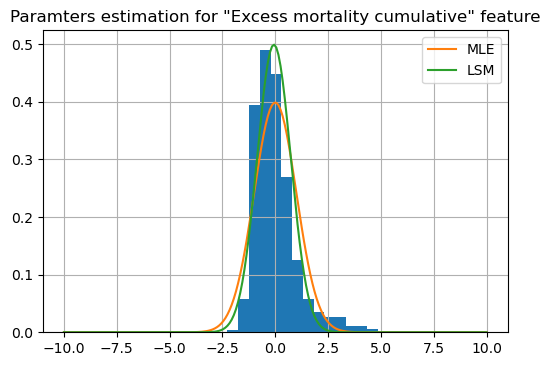

In [26]:
mpl.rcParams['figure.dpi'] = 100
emc.hist(bins=15, density=True)
space = np.linspace(-10, 10, 200)
plt.plot(space, norm.pdf(space, *emc_mle), label='MLE')
plt.plot(space, norm.pdf(space, *emc_lsm), label='LSM')
plt.title('Paramters estimation for "Excess mortality cumulative" feature')
plt.legend()

## Step 6. Validate your estimated parameters using QQ biplots

In [27]:
from math import sqrt

# Calculating confidence intervals for 25%, 50% and 75% quantiles
def conf_intervals(data, qn):
    # 95% quantile of Gaussian distribution
    norm_q95 = scipy.stats.norm.ppf(0.95)
    kernel = scipy.stats.gaussian_kde(data)

    p25 = len(data[data < qn[5]]) / len(data)
    sigma25 = \
        (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[5])
    p50 = len(data[data < qn[10]]) / len(data)
    sigma50 = \
        (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[10])
    p75 = len(data[data < qn[15]]) / len(data)
    sigma75 = \
        (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[15])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75

    return [conf_q25, conf_q50, conf_q75]

def qq(data, theoretical, feature_name, method_name):
    # Построение квантильного биплота для двух случайных величин
    plt.figure(figsize=(6, 6))

    percs = np.linspace(0, 100, 21)
    qn_first = np.percentile(data, percs)
    qn_second = np.percentile(theoretical, percs)

    min_qn = np.min([qn_first.min(), qn_second.min()])
    max_qn = np.max([qn_first.max(), qn_second.max()])
    x = np.linspace(min_qn, max_qn)

    plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
    plt.plot(x, x, color="k", ls="--")
    plt.xlabel('Data')
    plt.ylabel('Theoretical')
    plt.xlim([min_qn, max_qn])
    plt.ylim([min_qn, max_qn])
    plt.grid(True)
    
    conf_first = conf_intervals(data, qn_first)
    conf_second = conf_intervals(theoretical, qn_first)
    
    conf_first_list = []
    conf_second_list = []
    for element1, element2 in zip(conf_first, conf_second):
        conf_first_list.append(element1[0])
        conf_second_list.append(element2[0])

    # Добавление доверительных интервалов на график
    plt.errorbar(
        # [25%, 50%, 75%]
        [np.percentile(data, 25), np.percentile(data, 50), np.percentile(data, 75)],
        [np.percentile(theoretical, 25), np.percentile(theoretical, 50), np.percentile(theoretical, 75)],
        xerr=conf_first_list,
        yerr=conf_second_list,
        ls='none',
        capsize=3,
        elinewidth=2
    )

    plt.title('QQ-plot for "' + feature_name + '" feature (' + method_name + ')')
    plt.show()

### Hospital beds per thousand

#### Maximum likelihood method

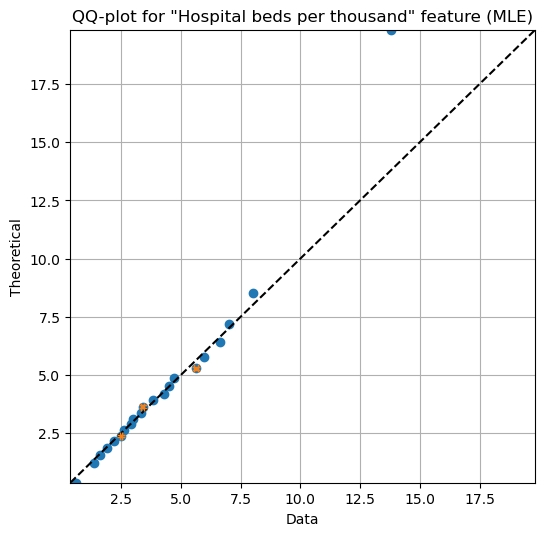

In [28]:
beds_theoretical_mle = gamma.rvs(*beds_mle, size=len(beds))
qq(beds, beds_theoretical_mle, 'Hospital beds per thousand', 'MLE')

#### Least squares method

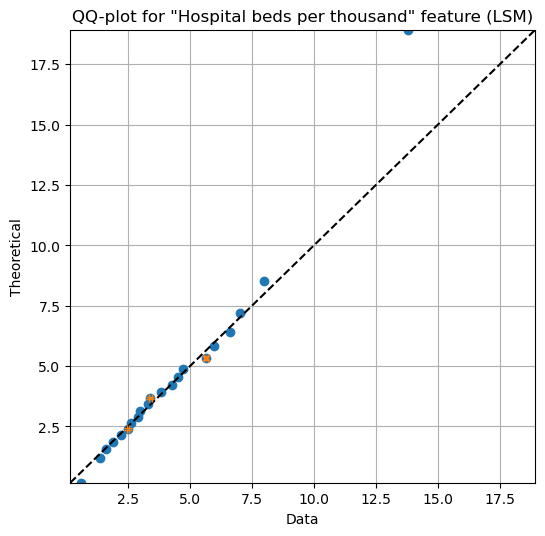

In [29]:
beds_theoretical_lsm = gamma.rvs(*beds_lsm, size=len(beds))
qq(beds, beds_theoretical_lsm, 'Hospital beds per thousand', 'LSM')

### Excess mortality cumulative per million

#### Maximum likelihood method

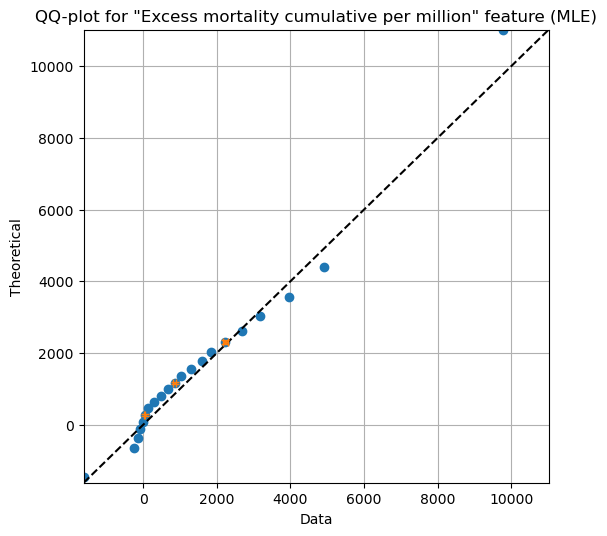

In [30]:
emcpm_theoretical_mle = chi2.rvs(*emcpm_mle, size=len(emcpm))
qq(emcpm, emcpm_theoretical_mle, 'Excess mortality cumulative per million', 'MLE')

#### Least squares method

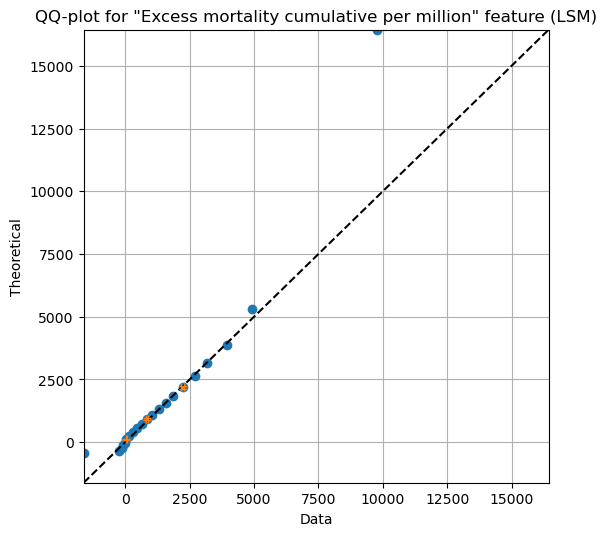

In [31]:
emcpm_theoretical_lsm = chi2.rvs(*emcpm_lsm, size=len(emcpm))
qq(emcpm, emcpm_theoretical_lsm, 'Excess mortality cumulative per million', 'LSM')

### Excess mortality cumulative

#### Maximum likelihood method

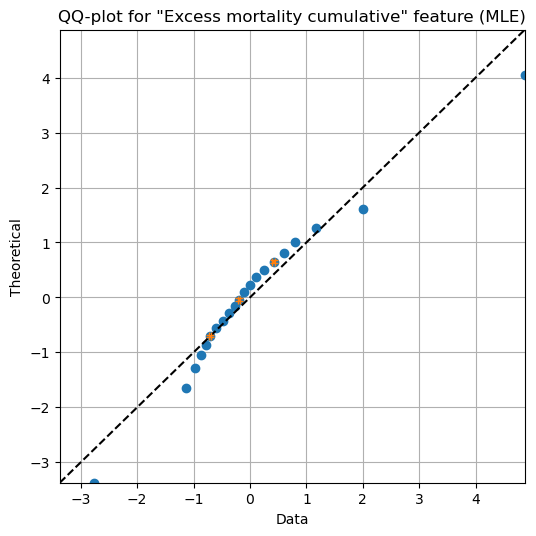

In [32]:
emc_theoretical_mle = norm.rvs(*emc_mle, size=len(emc))
qq(emc, emc_theoretical_mle, 'Excess mortality cumulative', 'MLE')

#### Least squares method

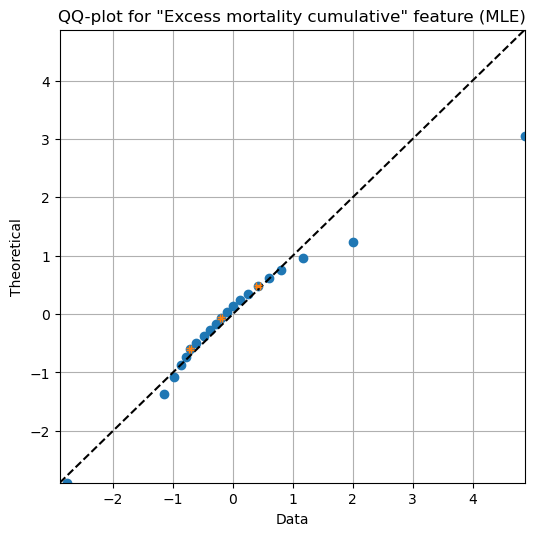

In [33]:
emc_theoretical_lsm = norm.rvs(*emc_lsm, size=len(emc))
qq(emc, emc_theoretical_lsm, 'Excess mortality cumulative', 'MLE')

## Step 7. Estimate correctness of fitted distributions using at least 2 statistical tests.

In [34]:
def ks_test(data, distribution, params, alpha = 0.05, N = 50):
    ks = stats.kstest(data.sample(N), distribution, params, N)
    if ks[1] > alpha:
        print(f'Kolmogorov test passed. Under the null hypothesis,\n the two {distribution} distributions are identical')
    else:
        print(f"Kolmogorov test failed. Hypothesis about {distribution} is false")
    print(ks)

def cvm_test(data, distribution, params, alpha = 0.05):
    cvm = stats.cramervonmises(data.sample(50), distribution, params)
    if cvm.pvalue > alpha: 
        print(f"Cramer-von-Mises test passed. Hypothesis about that distribution \n have cumulative {distribution} distribution is true")
    else:
        print(f"Cramer-von-Mises failed. We reject the null hypothesis \n that the observed sample is drawn from a {distribution} distribution")
    print(cvm)
    print('\n')

In [35]:
def statistical_tests(data, distribution, params, alpha = 0.05, N = 50):
    ks_test(data, distribution, params, alpha, N)
    print('\n')
    cvm_test(data, distribution, params, alpha)

### Hospital beds per thousand

In [36]:
statistical_tests(beds, 'gamma', beds_mle, alpha = 0.05, N = 50)
statistical_tests(beds, 'gamma', beds_lsm, alpha = 0.05, N = 50)

Kolmogorov test failed. Hypothesis about gamma is false
KstestResult(statistic=0.2061544424856646, pvalue=0.024294473892145674)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative gamma distribution is true
CramerVonMisesResult(statistic=0.10000427646855142, pvalue=0.5866776862021934)


Kolmogorov test passed. Under the null hypothesis,
 the two gamma distributions are identical
KstestResult(statistic=0.09395040641905084, pvalue=0.7340582631697208)


Cramer-von-Mises failed. We reject the null hypothesis 
 that the observed sample is drawn from a gamma distribution
CramerVonMisesResult(statistic=0.5409605925771679, pvalue=0.030973666171440928)




### Excess mortality cumulative per million

In [37]:
statistical_tests(emcpm, 'chi2', emcpm_mle, alpha = 0.05, N = 50)
statistical_tests(emcpm, 'chi2', emcpm_lsm, alpha = 0.05, N = 50)

Kolmogorov test passed. Under the null hypothesis,
 the two chi2 distributions are identical
KstestResult(statistic=0.15249312385871466, pvalue=0.17609550323567502)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative chi2 distribution is true
CramerVonMisesResult(statistic=0.22316722424982574, pvalue=0.22701199784912185)


Kolmogorov test passed. Under the null hypothesis,
 the two chi2 distributions are identical
KstestResult(statistic=0.17776063551716648, pvalue=0.07468582301765558)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative chi2 distribution is true
CramerVonMisesResult(statistic=0.12151344898999245, pvalue=0.49077941432289474)




### Excess mortality cumulative

In [38]:
statistical_tests(emc, 'norm', emc_mle, alpha = 0.05, N = 50)
statistical_tests(emc, 'norm', emc_lsm, alpha = 0.05, N = 50)

Kolmogorov test failed. Hypothesis about norm is false
KstestResult(statistic=0.2318176942901835, pvalue=0.007604132696947596)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative norm distribution is true
CramerVonMisesResult(statistic=0.2857963989625446, pvalue=0.14821549799993028)


Kolmogorov test passed. Under the null hypothesis,
 the two norm distributions are identical
KstestResult(statistic=0.16067399579100816, pvalue=0.13535676362577787)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative norm distribution is true
CramerVonMisesResult(statistic=0.3550886419928707, pvalue=0.09495671331731559)


